<font size="6.5">**Joint Distribution Fitting for Two Resources**

<font size="3">This file takes raw transaction data as an input. We model the two resources, gas and calldata length, jointly by identifying and separately modeling clusters of the data. The output is a list of generated transactions jointly distributed with resources gas and calldata length. The goal of this file is to find various clusters in the raw dataset and model them with multiple joint distributions. Then, we can simulate transactions based on the estimated parameters of the cluster distributions.

    
<font size="3">The input file TxF22.csv is generated with **Yik's file that pulls from the chain**

In [143]:
#Import necessary packages and raw data file

import sys; sys.path.insert(0, '..')  # this adds the parent directory into the path, since we want simulations from the parent directory
from settings import DATA_PATH

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import Counter 
from math import e
from random import randint

file='TxF22.csv'
data=pd.read_csv(str(DATA_PATH / file)) 


<font size="5">**Data Partitioning and Cleaning**
    
<font size="3">We split the data into training and test sets so that we can fit the distributions on the training data and evaluate fitment on the test data. To fit, we first remove the lower gas limit values (gas of 21000). In the transaction generation cell, we include these by modeling this value at the proportion that it appears in the dataset. 
    
> where is the sampling happening in your code? All I see happening is TxGas and TxCallData being shuffled and a dataframe being created.**
    
>>This was accidentally carried over from the marginal distribution code. There is no splitting into test and training here, although that would be a good idea to incorporate here. also no 21k removal

In [144]:
TxGas=list(data['gas']) #gas used per Tx
TxCallData=list(data['input']) 
TxCallData=[len(x[2:]) for x in TxCallData] #length of calldata after '0x' string for each entry

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})


<font size="5">**Histograms and Scatter of Calldata Length vs Gas on a Log-Log Scale**
    
<font size="3">Visualizing the data on a log-log scale clearly shows various clusters of data. To understand the data better, we can identify clusters (in later cells) and fit separate distributions to the data at fixed gas and/or calldata length values.
    
> YZ: calldata is one word - fix everywhere
>> fixed everywhere
    
> this section is a bit academic. Make it clearer:
    
> 1) "improve upon marginal distribution modeling" seems off-point and obtuse. Just "to understand the data better" is good enough
>> changed but the reason i wrote it like that is to say that this is a more complex and probably better way than marginal distribution modeling.
    
> 2) the "fixed values" thing is fine, but can be more descriptive and intuitive. Something like: "notice we have some data that appear as horizontal and vertical (?) lines. These correspond to clusters of data at fixed gas and/or calldata length values. We can separate these out." etc.
    
> Notice you are talking about a graphic that happens *after* you talk about it. One alternative is to make the graphic first, then it flows more naturally into your narrative.

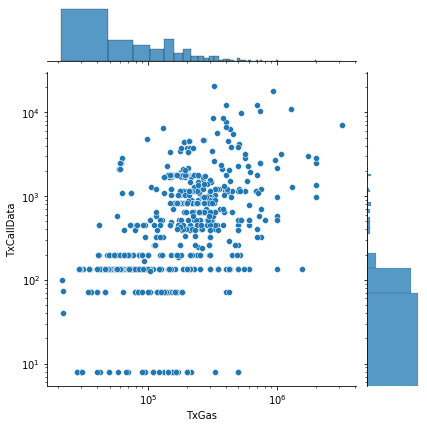

In [145]:
jp=sns.jointplot(data=df, x="TxGas", y="TxCallData");
jp.ax_joint.set_xscale('log')
jp.ax_joint.set_yscale('log')

For Below Code (improved Tx generation using joint densities):

Ex. For gasVal=90000 , gasValCount=32, the ratio is >2% so add to commonGas list that goes into plot vert line then loop thru the calldata values for 90k. 136, 200, 0, 72, and 8 (CallDataLen values in loop 2). need to isolate any CallDataLen that have count (CallDataLenCount) ratios > limit and include them in a model that generates them. For example, if gas 90k has lots of callData at len 200, then generate those at the % they appear in the dataset. then remove from set check if the other calldata lengths at same gas value are over limit.

dfRemaining is filtered by how many different calldata values are associated with each gas value (minNumGasValsForDistr variable defines this). The commonDFRemainingGas df is made to define at which gas values we will generate points from using a distribution, while commonDf will generate gas and CD values if that specific combo of gas and CD is common (more than ratioLimitGas).

Point generation means we generate using a specific calldata length and gas value. The leftover calldata values can be modeled using a distribution if they don't individually contribute to a large proportion of the dataset.

> I don't see any "below code" and I find this portion more like notes and less like narrative. Is it intended to be "notes to self" or read by the reader? If the latter, please give more context and use clearer sentence strucutres.

>> my mistake, this was notes to self i meant to delete

<font size="5">**Set Conditions for Determining Clusters**
    
<font size="3">If the proportion of gas values at a given gas value is larger than the ratioLimitGas variable (or ratioLimitCallData in separately considered CD values), we will create special conditions to generate points from a different joint distribution. 
  
<font size="3">This is first used to see if any gas value occurs at least this often in the set. Then if any corresponding calldata length value occurs at that gas value over this ratio, we will later generate this exact gas and calldata value at the proportion we see it in the set. If the there are other calldata values corresponding to the current gas value being evaluated, we check if they all make up a total of over this ratio and generate from a distribution later (using gamma parameters estimated from calldata lengths at this gas value).
    
<font size="3">We also set lenGenerated to define how many transactions we wish to simulate.
    
> I like the level of detail here. Just make it a bit easier for the reader. Saying things like "this often" or "this ratio" is wasting the time you used to define stuff. Just allude to the variables with e.g. ``ratioLimitGas``

In [146]:
   
#Find most common Gas
ratioLimitGas=0.02 #If the count of gas values divided by the total values is over this ratio, we will create special conditions to generate points from another joint distribution. This is first used to see if any gas val occurs at least this often in the set. Then if any corresponding cd len value occurs at that gas value over this ratio, we will later generate this exact gas and cd value at the proportion we see it in the set. If the there are other cd values corresponding to the current gas value being evaluated, we check if they all make up a total of over this ratio and generate from a distribution later (using parameters derived from cd lengths at this gas value). Note a limitation of this methodology is that it's possible for a gas value to have a specific cd length over this ratio and the rest of the cd values not summing to over this ratio. Therefore, the current code will not incorporate these points when generating the joint distribution.  
ratioLimitCallData=ratioLimitGas
minNumGasValsForDistr=2      #if set to 2 for example, only generates from a distribution if that gas value occurs 3+ times (not including any gas,cd combinations that were at a proportion > the ratio limits)
minNumCallDataValsForDistr=1 #if set to 2 for example, only generates from a distribution if that CD  value occurs 3+ times (not including any gas,cd combinations that were at a proportion > the ratio limits)
lenGenerated=1000 #number of Txs to be jointly simulated. Instead of looping thru this length, we multiply each cluster proportion by this to end up with realistic ratios of clusters being generated.


<font size="5">**Finding 'Point' Clusters and Fixed Gas Value Clusters**
    
<font size="3">We loop through all gas values in the dataset and evaluate if any calldata length and gas value combinations make up more than ratioLimitGas of the set (i.e. >2% of the data). If there are any, we store these and later we create the specialGeneration df with these entered as type 'Point'. We can then look at all other calldata length values at each gas value and see if their proportions sum to more than the ratioLimitGas. If so, these are stored and later we create the specialGeneration df with these entered as type 'GasDistribution'. These are also stored in commonGas to be used in the chart as red vertical lines.
    
> when refering to variables, use monospaced font for better guidance. Like ``commonGas``
    
> "combinations" is a bit vague. I'd maybe change the narrative structure. Maybe something like "We say that (x,y) where x is a gas value and y is a calldata length constitutes a "Point distribution" if they make up more than ratioLimitGas of the set"...

In [147]:
commonGas=[]
topGasPoints=[]
topGasDistr=[]

for gasVal,gasValCount in (dict(Counter(df.TxGas)).items()): 
    if gasValCount/len(df) > ratioLimitGas: #if gas value is present in high proportion of dataset
        s=0
        commonGas.append(gasVal) #used later to make vertical lines in plot
        for CallDataLen,CallDataLenCount in dict(Counter(list(df[df.TxGas==gasVal].TxCallData))).items():
            if CallDataLenCount/len(df) > ratioLimitGas: 
                topGasPoints.append((gasVal,list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(df),3),len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:])))
            else:
                topGasDistr.append((gasVal,list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(df),3),len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:])))
            s=s+1

commonDf=pd.DataFrame(topGasPoints,columns=['Gas Value','Calldata Length','Ratio of Dataset','# times in set'])

commonDFRemainingGas=pd.DataFrame(topGasDistr,columns=['Gas Value','Calldata Length','Ratio of Dataset','# times in set'])
vc = commonDFRemainingGas['Gas Value'].value_counts()         
commonDFRemainingGas=commonDFRemainingGas[commonDFRemainingGas['Gas Value'].isin(vc.index[vc.gt(minNumGasValsForDistr)])]

countGasLens=commonDFRemainingGas.groupby('Gas Value').count()['# times in set']
commonDFRemainingGas=commonDFRemainingGas.drop(columns=['# times in set']) #drop column
commonDFRemainingGas=commonDFRemainingGas.groupby(by=["Gas Value"]).sum() 
commonDFRemainingGas['# Corresponding CD Values in Set After Point Generation']=countGasLens
commonDFRemainingGas=commonDFRemainingGas.drop(columns=['Calldata Length']) #drop irrelevant column
commonDFRemainingGas=commonDFRemainingGas[commonDFRemainingGas['Ratio of Dataset'] >=ratioLimitGas] #look at the ratio of the dataset that each gas value encompasses across all CD values



<font size="5">**Finding Fixed Calldata Length Value Clusters**
    
<font size="3">We loop through all calldata length values in the dataset and evaluate if any make up more than ratioLimitCallData of the set (i.e. >2% of the data). We can then look at all gas values at each calldata length and see if their proportions sum to more than the ratioLimitCallData. If so, these are stored and later we create the specialGeneration df with these entered as type 'CDDistribution'. These are also stored in commonCallData to be used in the chart as green horizontal lines.
    
> instead of copying/pasting, I'd probably merge this markdown cell with the above and just tell the reader you are effectively doing the same thing twice.
    
> Also consider refactoring the code so you aren't doing the same code twice.

In [148]:
commonCallData=[]
topCallDataDistr=[]
for callDataVal,callDataValCount in (dict(Counter(df.TxCallData)).items()): 
    if callDataValCount/len(df) > ratioLimitCallData: #if cd is present in high proportion of dataset
        s=0
        commonCallData.append(callDataVal) #used later to make vertical lines in plot
        for gasLen,gasLenCount in dict(Counter(list(df[df.TxCallData==callDataVal].TxGas))).items():
            if gasLenCount/len(df) > ratioLimitCallData: 
                continue #no need to repeat for calldata points bc will be the same as topGasPoints. specialGeneration Type: 'Points' already covered 
            else:
                topCallDataDistr.append((list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[s],callDataVal,round(gasLenCount/len(df),10),     len(list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[:])))
            s=s+1

commonDFRemainingCallData=pd.DataFrame(topCallDataDistr,columns=['Gas Value','Calldata Length','Ratio of Dataset','# times in set'])
vc = commonDFRemainingCallData['Calldata Length'].value_counts()         
commonDFRemainingCallData=commonDFRemainingCallData[commonDFRemainingCallData['Calldata Length'].isin(vc.index[vc.gt(minNumCallDataValsForDistr)])] #This determines how many points needed to estimate distribution parameters. if not enough, no generation occurs.

countCDLens=commonDFRemainingCallData.groupby('Calldata Length').count()['# times in set']
commonDFRemainingCallData=commonDFRemainingCallData.drop(columns=['# times in set']) #drop column
commonDFRemainingCallData=commonDFRemainingCallData.groupby(by=["Calldata Length"]).sum() 
commonDFRemainingCallData['# Corresponding Gas Values in Set After Point Generation']=countCDLens 
commonDFRemainingCallData=commonDFRemainingCallData.drop(columns=['Gas Value']) #drop irrelevant column
commonDFRemainingCallData=commonDFRemainingCallData[commonDFRemainingCallData['Ratio of Dataset'] >=ratioLimitCallData] #look at the ratio of the dataset that each cd value encompasses across all gas values


<font size="5">**Merging Data Frames to Define Clusters**
    
<font size="3">We merge the most common points, and distributions along fixed gas and calldata lengths. This is later used to estimate gamma parameters and generate transactions.
    
> This is the kind of language that's useful for a note to yourself, but probably not to someone reading it. Give the readers a bit more lookahead. Where are we going? (it could be somewhere obvious)
    
> (I don't even know if I'm right, since I am not on the same page as you) maybe something like "Now we identified the Point (and what else?) clusters, we merge them and find parameters used to generate them (?) using Gamma distributions (?). The idea is after accounting for these "point" and "line" clusters, we will model the remaining with a single 2-d Gaussian (?) distribution. Combining the points, lines, and gaussians then gives a way of generating transactions for any future simulation.

In [149]:
#Now merge DFs together that identify gas,cd points for special Tx generation as well as individual gas and cd values that will have distributions fit and generated randomly from them
commonDf['Type'] = 'Point'#this is all the gas,cd common points that will be generated at the proportion they appear in the dataset
commonDFRemainingGas['Type'] = 'GasDistribution'
commonDFRemainingCallData['Type'] = 'CDDistribution'

tempDf=commonDf.merge(commonDFRemainingGas, how='outer', on=['Gas Value','Ratio of Dataset','Type'])
specialGeneration=tempDf.merge(commonDFRemainingCallData, how='outer', on=['Calldata Length','Ratio of Dataset','Type']).drop(columns=['# times in set','# Corresponding CD Values in Set After Point Generation','# Corresponding Gas Values in Set After Point Generation'])
#display(specialGeneration)


<font size="5">**Cluster Identification Chart**
    
<font size="3">Green horizontal lines represent calldata lengths that appear at more than ratioLimitCallData, while red vertical lines represent gas values that appear at more than ratioLimitGas.
    
> if you are describing a graphic, show the graphic first.
    
> There is a refactor possibility here. See my commented out code below.
    
>>refactor?
    
> In general, try not to copy/paste any code

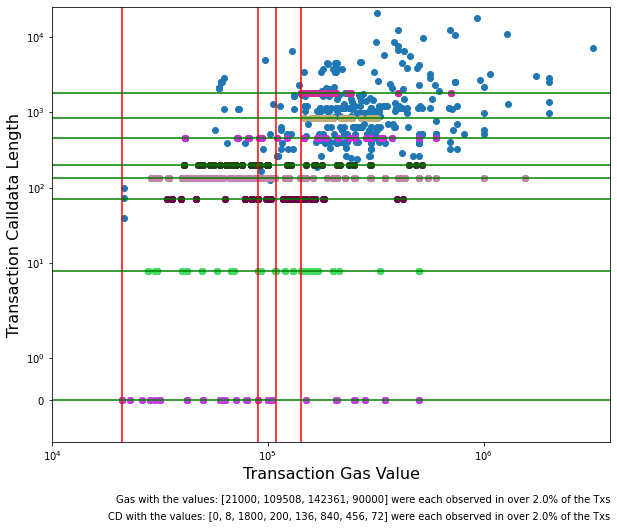

In [150]:
#Create plots of CD vs Gas
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df['TxGas'],df['TxCallData'])
ax.set_xscale('symlog')
ax.set_yscale('symlog')

colors = []
for i in range(len(commonCallData)):
    random.seed(i*22)
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
ss=0
for i in commonCallData:
    ax.scatter(df[df['TxCallData']==i].TxGas,df[df['TxCallData']==i].TxCallData,color=colors[ss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ss=ss+1

colors2 = []   
for i in range(len(commonGas)):
    random.seed(i*8)
    colors2.append('#%06X' % randint(0, 0xFFFFFF))

sss=0
for i in commonGas:
    ax.scatter(df[df['TxGas']==i].TxGas,df[df['TxGas']==i].TxCallData,color=colors2[sss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    sss=sss+1
    
# refactor possibility:

#def make_colors(seed_mult):
#  colors = ['#%06X' % randint(0, 0xFFFFFF)]
#  for i in range(len(commonCallData)):
#    random.seed(seed_mult*22)
#    colors.append('#%06X' % randint(0, 0xFFFFFF))
#  return colors

#colors = make_colors(22)
#colors2 = make_colors(8)

#def make_graph(data_source, name, colors):
#  count=0
#  for i in data_source:
#    ax.scatter(df[df[name]]) ... = ... color=colors[count]
#  return count    

#ss = make_graph(commonCallData, 'TxCallData', colors)
#sss = make_graph(commonGas, 'TxGas', colors2)

    
ss=0
for i in commonCallData:
    ax.scatter(df[df['TxCallData']==i].TxGas,df[df['TxCallData']==i].TxCallData,color=colors[ss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ss=ss+1

    
    
for i in range(len(commonGas)):
    plt.axvline(x=commonGas[i],color='r')    
for i in range(len(commonCallData)):
    plt.axhline(y=commonCallData[i],color='g')    

ax.annotate('Gas with the values: '+str(commonGas)+' were each observed in over '+str(100*ratioLimitGas)+'% of the Txs',xy = (1, -0.13),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('CD with the values: '+str(commonCallData)+' were each observed in over '+str(100*ratioLimitCallData)+'% of the Txs',xy = (1, -0.17),xycoords='axes fraction',ha='right',va="center",fontsize=10)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Calldata Length', fontsize=16)
plt.xlim([1e4, np.max(df.TxGas)*1.2])
plt.ylim([-1, np.max(df.TxCallData)*1.2])

plt.show()


<font size="5">**Parameter Estimation**
    
<font size="3">For commonly seen gas values, the gas value is fixed and calldata lengths are used to estimate gamma parameters. For commonly seen calldata lengths, the calldata length is fixed and gas values are used to estimate gamma parameters.
    
> I really like this picture above.
    
> The horizontal green lines feel "real" but the vertical red lines don't really feel "real"? (Like are there any real-world reasons they would exist?) If they arent, maybe we should just do green lines?
    
>> agreed, might just need to incrfease ratioLimitGas

In [151]:
#Now find gamma parameters for clusters:

specialGeneration['Alpha Gamma Parameter']='NaN'
specialGeneration['Beta Gamma Parameter']='NaN'


for i in range(len(specialGeneration)): 
    if specialGeneration['Type'].loc[i]=='GasDistribution':
        specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   ))**2/np.var( df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   )
        specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   ))/np.var( df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   )
    if specialGeneration['Type'].loc[i]=='CDDistribution':
        specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  df[df.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   ))**2/np.var( df[df.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   )
        specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  df[df.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   ))/np.var( df[df.TxCallData==specialGeneration['Calldata Length'][i]].TxGas   )
        
        
display(specialGeneration)


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Gas Value,Calldata Length,Ratio of Dataset,Type,Alpha Gamma Parameter,Beta Gamma Parameter
0,21000.0,0.0,0.183000,Point,NaN,NaN
1,109508.0,8.0,0.023000,Point,NaN,NaN
2,142361.0,8.0,0.042000,Point,NaN,NaN
3,90000.0,NaN,0.023000,GasDistribution,3.342016,0.023088
4,NaN,0.0,0.046562,CDDistribution,0.427091,0.00001
5,NaN,8.0,0.055158,CDDistribution,3.601112,0.000026
6,NaN,72.0,0.075931,CDDistribution,4.29938,0.000037
7,NaN,136.0,0.227794,CDDistribution,0.654086,0.000006
8,NaN,200.0,0.059456,CDDistribution,1.563451,0.000014
9,NaN,456.0,0.020057,CDDistribution,2.347841,0.000011


<font size="5">**Transaction Generation**
    
<font size="3">We loop through all entries in the specialGeneration df and generate transactions at the proportion that that cluster appears in the raw dataset. We simultaneously drop rows from the dfRemaining df to make a set of the remaining data that must be generated.
    
> As before, this writing seems to be more for you but not for the reader.

In [152]:
TxGenerated=[] # list of (gas,CD) tuples
dfRemaining=df #initialize with full df and then reduce rows

for i in range(len(specialGeneration)): 
    if specialGeneration['Type'].loc[i]=='GasDistribution':
        dfRemaining=dfRemaining.drop(dfRemaining[dfRemaining.TxGas == specialGeneration['Gas Value'][i]].index)
        TxGenerated=TxGenerated+(  list(zip( [specialGeneration['Gas Value'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i])    ,            list(stats.gamma.rvs(specialGeneration['Alpha Gamma Parameter'].loc[i], scale=1/specialGeneration['Beta Gamma Parameter'].loc[i],size=round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) ))))     )
    if specialGeneration['Type'].loc[i]=='CDDistribution':
        dfRemaining=dfRemaining.drop(dfRemaining[dfRemaining.TxCallData == specialGeneration['Calldata Length'][i]].index)
        TxGenerated=TxGenerated+(  list(zip(    list(stats.gamma.rvs(specialGeneration['Alpha Gamma Parameter'].loc[i], scale=1/specialGeneration['Beta Gamma Parameter'].loc[i],size=round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) )), [specialGeneration['Calldata Length'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) ))     )
    if specialGeneration['Type'].loc[i]=='Point':
        dfRemaining=dfRemaining.drop(dfRemaining[(dfRemaining.TxCallData == specialGeneration['Calldata Length'][i]) & (dfRemaining.TxGas == specialGeneration['Gas Value'][i])].index)
        TxGenerated=TxGenerated+(  list(zip(    [specialGeneration['Gas Value'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i])   ,                         [specialGeneration['Calldata Length'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) )))
remainingLength=lenGenerated-round(np.sum(lenGenerated*specialGeneration['Ratio of Dataset']) )



<font size="5">**Visualization of Remaining Data**
    
<font size="3">All previously unmodeled data is plotted here. These are data that were not identified clusters, but must stil be modeled. On a log-log scale, data appears Gaussian.
    
> Good cell mostly. 
    
> Define "unmodeled". Be specific and use earlier language, such as "all data we didn't classify as 'clusters'"

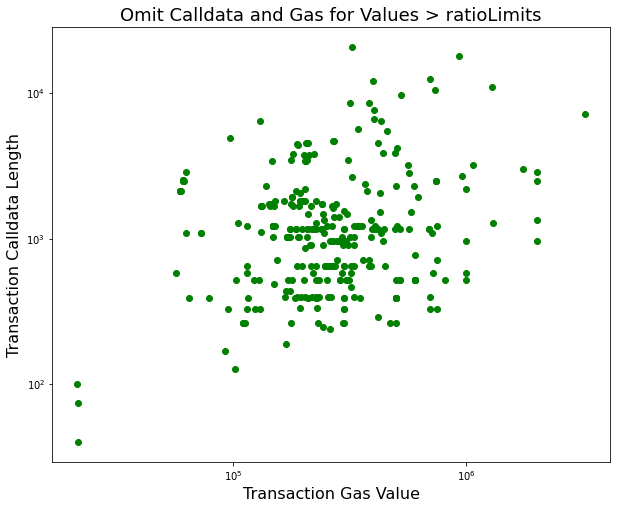

In [153]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(dfRemaining['TxGas'],dfRemaining['TxCallData'],c='g')
ax.set_xscale('symlog')
ax.set_yscale('symlog')
plt.title('Omit Calldata and Gas for Values > ratioLimits', fontsize=18)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Calldata Length', fontsize=16)
plt.show()


<font size="5">**Generating Remaining Data**
    
<font size="3">All unmodeled data can be modeled as a multivariate log-normal distribution. We use the remaining set to estimate parameters and then generate transactions following this distribution at the propotion they appear in the raw data.

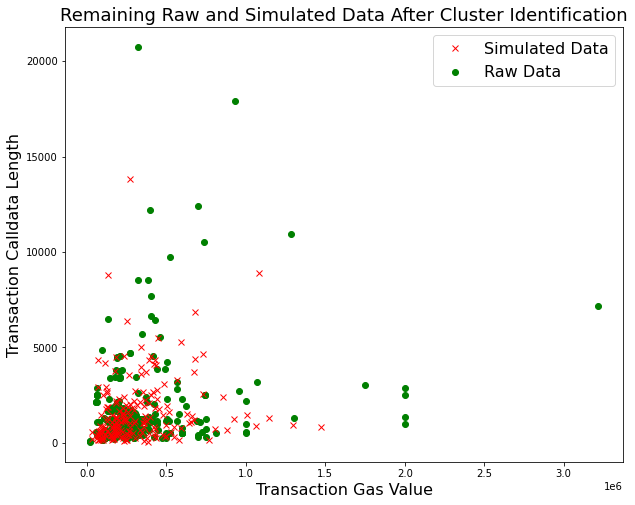

In [154]:
#Model the rest of the data
logGas=np.log(dfRemaining['TxGas'])
logCallData=np.log(dfRemaining['TxCallData'])
logCovMat=np.cov(logGas,logCallData)
logMuGas=np.mean(logGas)
logMuCallData=np.mean(logCallData)

#fig, ax = plt.subplots()
fig,ax=plt.subplots(figsize=(10,8))
x, y = np.random.multivariate_normal([logMuGas,logMuCallData], logCovMat, remainingLength).T
ax.scatter(dfRemaining['TxGas'],dfRemaining['TxCallData'],color='g',label='Raw Data')
plt.plot(e**x, e**y, 'x',color='r',label='Simulated Data')
plt.title('Remaining Raw and Simulated Data After Cluster Identification', fontsize=18)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Calldata Length', fontsize=16)
plt.legend(fontsize=16)
plt.show()

TxGenerated=TxGenerated+( list(zip(e**x,e**y)) )   


<font size="5">**Comparing Raw and Simulated Data**
    
<font size="3">To evaluate the effectiveness of the simulation, we can compare the simulated data to the raw data. **Note: FIND SOME METRICS TO COMPARE 2D DISTRIBUTIONS... NO 2D KOLMOGOROV IN PYTHON PACKAGES**
    
> See my comments in discord.

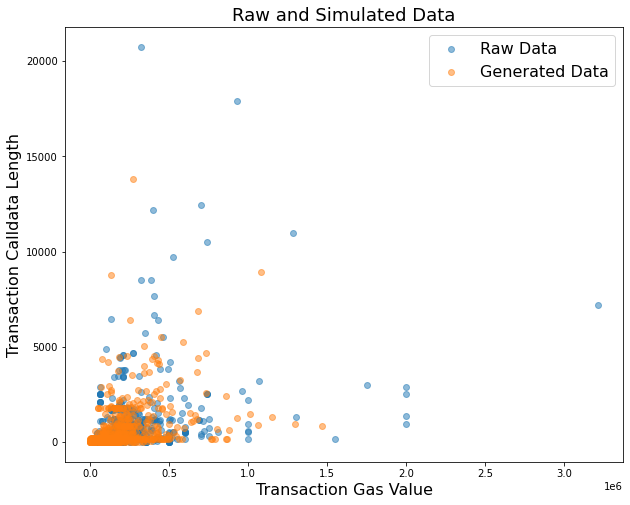

In [155]:
TxGeneratedGas=[TxGenerated[i][0] for i in range(len(TxGenerated))]
TxGeneratedCallData=[TxGenerated[i][1] for i in range(len(TxGenerated))]

fig,ax=plt.subplots(figsize=(10,8))
ax.scatter(df['TxGas'],df['TxCallData'],alpha=.5,label='Raw Data')
ax.scatter(TxGeneratedGas,TxGeneratedCallData,alpha=.5,label='Generated Data')
plt.title('Raw and Simulated Data', fontsize=18)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Calldata Length', fontsize=16)
plt.legend(fontsize=16)
plt.show()
